In [45]:
!apt-get update
!apt-get install -y tesseract-ocr
!pip install pytesseract opencv-python-headless Pillow scipy

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 129 kB in 2s (82.8 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 

In [46]:
import cv2
import numpy as np
import requests
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
from io import BytesIO
import pytesseract
from scipy.ndimage import interpolation as inter

In [47]:
def download_image(img_url):
    try:
        response = requests.get(img_url)
        response.raise_for_status()  # check if the request was successful
        img = Image.open(BytesIO(response.content))
        return img
    except requests.exceptions.RequestException as err:
        print(f"Error downloading image: {err}")
        return None

In [48]:
def preprocess_image1(img):
    try:

        img_np = np.array(img)

        # Calculate rotation angle and rotate image
        angle, corrected = correct_skew(img_np)
        img = Image.fromarray(corrected)

        img_gray = img.convert('L')

        # binary thresholding to make more distinguishable from background
        binary_img = img_gray.point(lambda p: 255 if p >= 127 else 0)

        # Invert colors (works better with white background and black text)
        binary_img = ImageOps.invert(binary_img)

        img = ImageEnhance.Contrast(binary_img).enhance(6)
        img.show()
        return img
    except Exception as err:
        print(err)
        return img  # return original image if process fails


In [49]:
def preprocess_image2(img):
    img = img.convert('L')

    # adding just the perfect amount of both contrast and Sharpness
    img = ImageEnhance.Contrast(img).enhance(9)
    img = ImageEnhance.Sharpness(img).enhance(4)

    img_array = np.array(img)
    inverted = 255 - img_array
    flat = inverted.flatten()
    text_color = np.bincount(flat).argmax()  # is going to be 0 in pretty much all cases (black)

    # use binary thresholding to make the text more distinguishable
    img = img.point(lambda p: 255 if p > text_color else 0)
    img.show()
    return  img


In [50]:
def preprocess_image(img):
    #  choose which one to choose
    return preprocess_image1(img)
    # return preprocess_image2(img)
    # return preprocess_image3(img)


In [51]:
# function below is not ours. It has not been written by any member of our tema
# the function is taken from Stackoverflow https://stackoverflow.com/questions/57964634/python-opencv-skew-correction-for-ocr
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        histogram, score = determine_score(thresh, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected


In [52]:
def extract_text_from_image(img):
    try:
        custom_config = r'--oem 3 --psm 6'
        return pytesseract.image_to_string(img, config=custom_config)  # return text
    except Exception as err:
        print(err)
        return ""


In [53]:
def extract_text_from_path(img_path):
    try:
        img = Image.open(img_path)
        img = preprocess_image(img)
        return extract_text_from_image(img)
    except Exception as err:
        print(err)
        return "Failed to process the image file"


In [54]:
def extract_text_from_url(img_url):
    try:
        img = download_image(img_url)
        if img is None:
            return "Failed to download the image file"
        #img = preprocess_image(img)
        return extract_text_from_image(img)
    except Exception as err:
        print(err)
        return "Failed to process the image file"

In [55]:
img_url = input("Enter image url: ")
print(extract_text_from_url(img_url))


Enter image url: https://trofeosgraboexpress.es/wp-content/uploads/2023/06/texto-placa-bodas-de-oro-3-3-scaled.jpg
Modas de |}
19067 by 2047
Gracias por hacer de vuestro amorun proyecto de vida
IG GUcwas pP or Crotarnos a formar pute de el.
Jos an efemplo a segue
; FELICIDADES !
7 de octubre de 2017



In [61]:
def preprocess_image_2(img):
    try:
        # Apply Gaussian blur to reduce noice and shadows of the letters
        img_blurred = img.filter(ImageFilter.GaussianBlur(1))
        # Convert to grayscale, this is necessary to process the img, despite being a black and white img already
        img_gray = img_blurred.convert('L')
        # Binarize the image
        img_np = np.array(img_gray)
        _, img_binarized = cv2.threshold(img_np, 128, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        # Convert back to PIL Image
        img_pil = Image.fromarray(img_binarized)
        img_pil.show()  # For debugging
        return img_pil
    except Exception as err:
        print(f"Error in preprocessing: {err}")
        return img

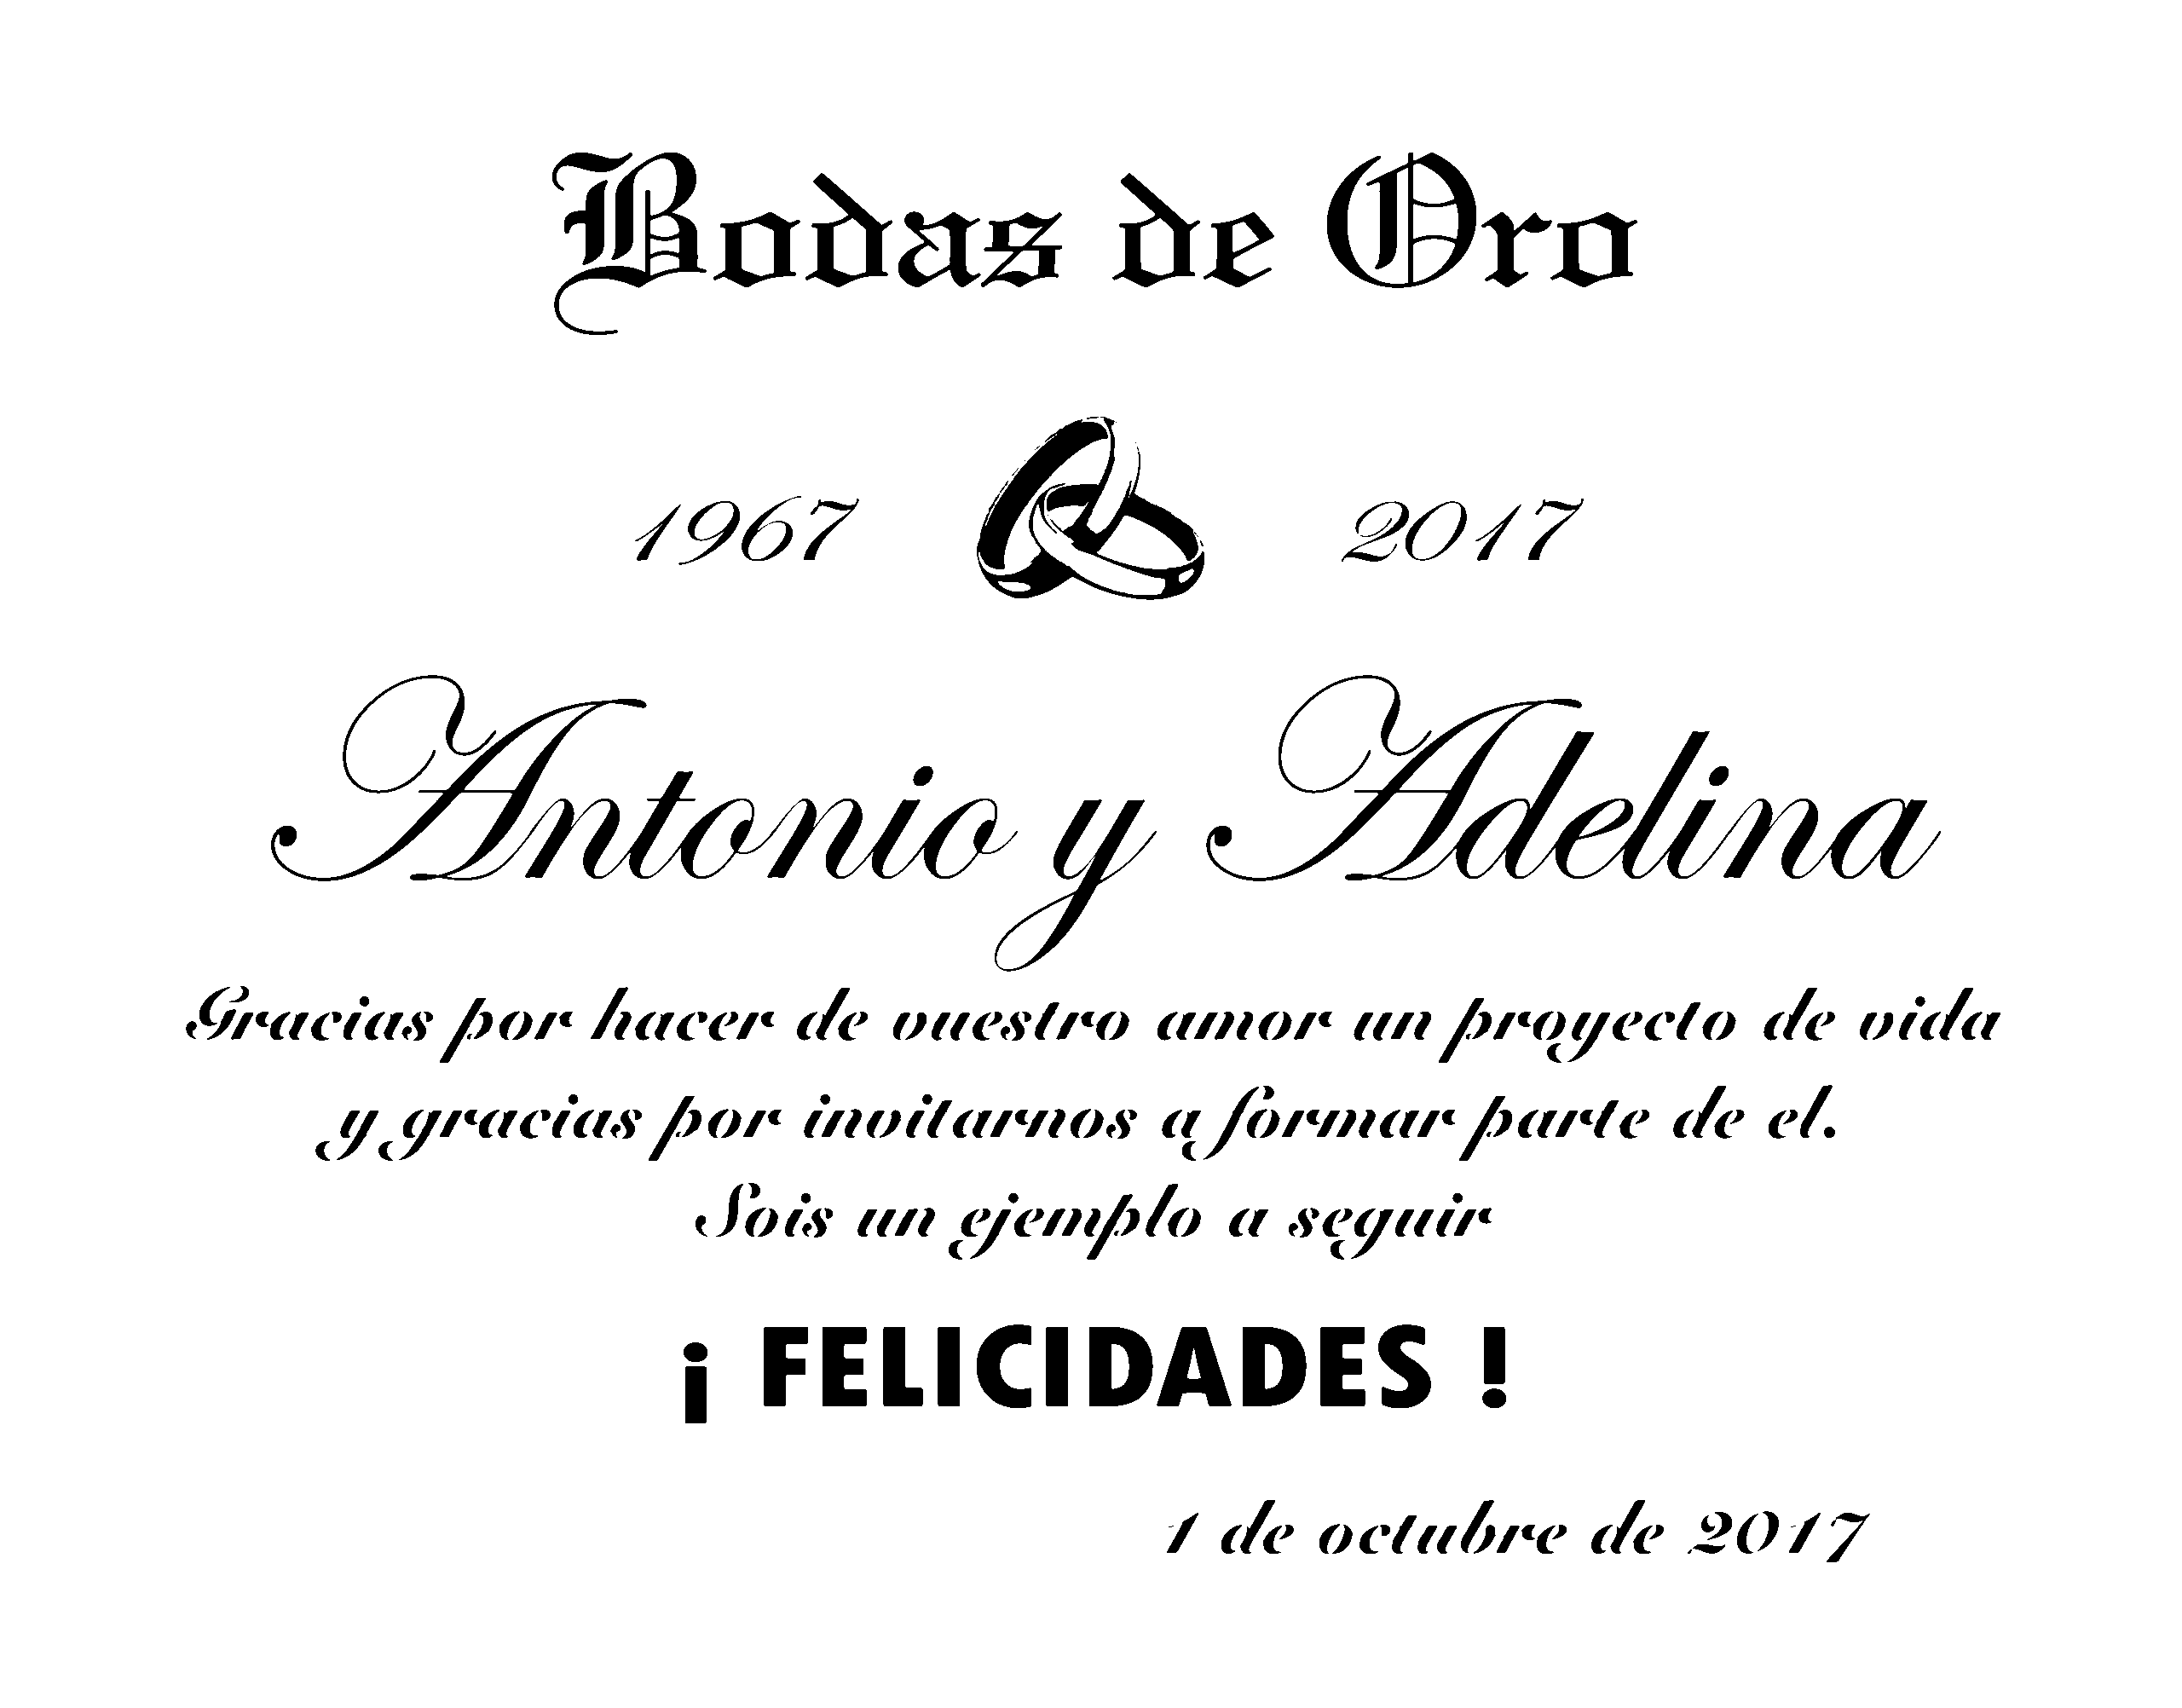

In [66]:
img_url = "https://trofeosgraboexpress.es/wp-content/uploads/2023/06/texto-placa-bodas-de-oro-3-3-scaled.jpg"
img = download_image(img_url)
img = preprocess_image_2(img)
img

In [65]:
print(extract_text_from_image(img))

Modas de D
1907 by 2017
GHactas por hacer de ouestro amoroun proyecto de vtda

I gracias por Modlargos a formar pute de el.

Jot un gemp loa segue

e@

; FELICIDADES !

1 de octubre de 207 7



In [69]:
img_url = "https://gdoc.io/uploads/high-school-diploma-free-google-docs-template-t-984x712.webp"
print(extract_text_from_url(img_url))

Harmony High School
This certifies that
Student Criselda (Vashington
has successfully completed the required
course of study and is awarded this
o o
High School Diploma
With all the rights, privileges, and responsibilities pertaining thereto.
School: Principal:
Flarmony Fligh School Anstruther Jienderson
Superintendent Pate: 10.12.24 Principal



In [71]:
img_url = "https://m.media-amazon.com/images/I/91ci4gnhJwL._AC_UF894,1000_QL80_.jpg"
print(extract_text_from_url(img_url))

anh Rapids Public s
i en ee ma ellie



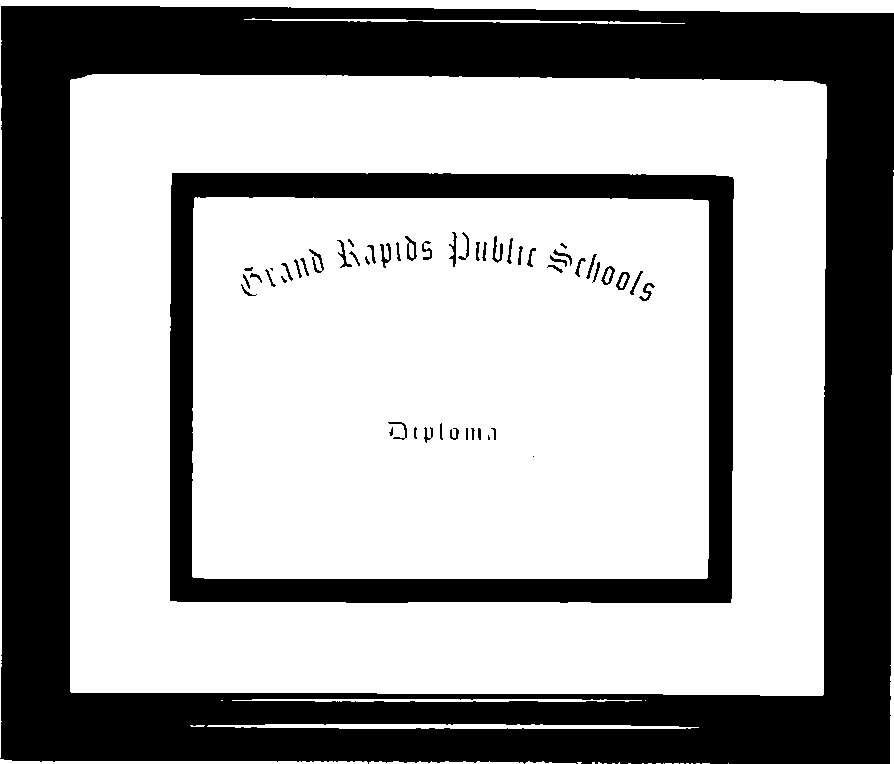

In [72]:
img_url = "https://m.media-amazon.com/images/I/91ci4gnhJwL._AC_UF894,1000_QL80_.jpg"
img = download_image(img_url)
img = preprocess_image_2(img)
img

In [92]:
def preprocess_image_3(img):
    try:
        # Grayscale
        img_gray = img.convert('L')
        # Enhance contrast
        img_contrast = ImageEnhance.Contrast(img_gray).enhance(2.0)
        # Edge enhancement
        img_edges = img_contrast.filter(ImageFilter.EDGE_ENHANCE_MORE)
        img_np = np.array(img_edges)
        # Binarize the image
        img_binarized = cv2.adaptiveThreshold(img_np, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        # Convert back to PIL Image
        img_pil = Image.fromarray(img_binarized)
        img_pil.show()
        return img_pil
    except Exception as err:
        print(f"Error in preprocessing: {err}")
        return img

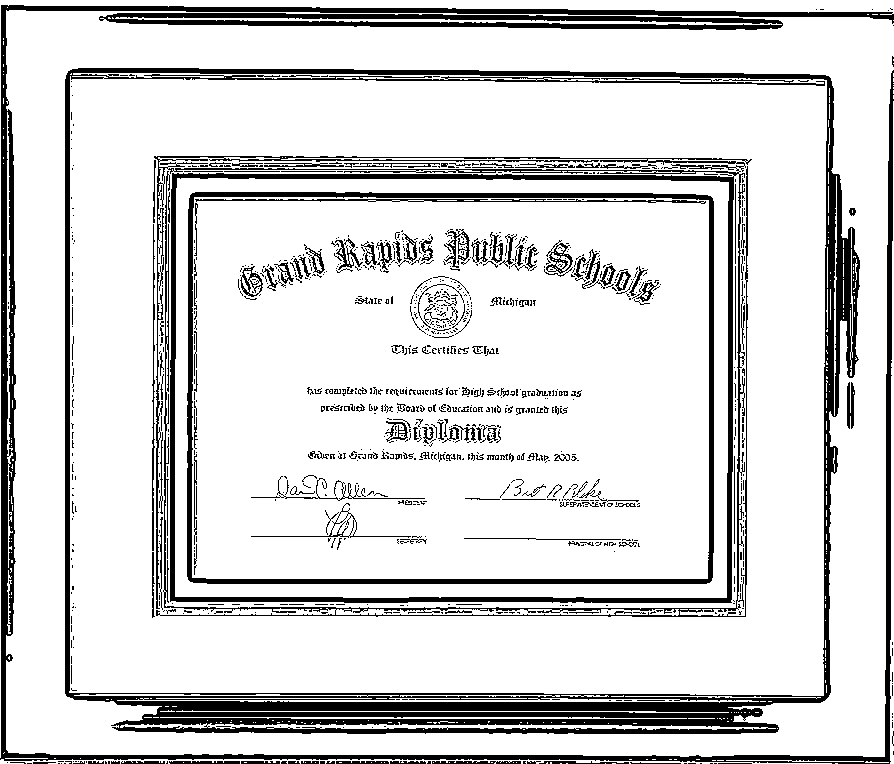

In [93]:
img_url = "https://m.media-amazon.com/images/I/91ci4gnhJwL._AC_UF894,1000_QL80_.jpg"
img = download_image(img_url)
img = preprocess_image_3(img)
img

In [94]:
print(extract_text_from_image(img))

——
'
| |
[.0m.,
ee
I} ol as oi
| cents But Ni
» | ! magic noc Bi Sct gtaess f
| | HY Biplons ii I
‘ ; i Gasen tr OFahe Kame, Mic, sis manth af Map, 2505. | if
CS ————————— }
r | ; |
ne |
SS |

